<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Feature Engineering </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (feature) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook](https://www.kaggle.com/code/rogeriodelfim/tps-nov-2022-01-eda-baseline), para isso vamos os seguintes passos: 

- Criar marcações levando em consideração a EDA realizada;
- Nova features estatísticas (sum, mean, etc);
- Feature de PCA; 
- Clusterização;
- Acrescentar as previsões geradas no notebook anterior ao dataset.

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [5]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

     |████████████████████████████████| 72 kB 647 kB/s 
     |████████████████████████████████| 569 kB 5.0 MB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Mounted at /content/drive


## 1.2. Bibliotecas 

In [6]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import multiprocessing
import glob
import glob
import pickle
import scipy.optimize 
import scipy.special

In [7]:
import pandas                    as pd
import numpy                     as np
import matplotlib.pyplot         as plt 
import seaborn                   as sns
import joblib                    as jb
import scipy.stats               as stats
import plotly.express            as px
import xgboost                   as xgb
import lightgbm                  as lgb
import scikitplot                as skplt
import sklearn.feature_selection as fs
import category_encoders         as ce

In [8]:
from matplotlib.axes._axes     import _log as matplotlib_axes_logger
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing     import StandardScaler,  OneHotEncoder, KBinsDiscretizer
from sklearn.metrics           import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics           import classification_report, confusion_matrix
from scipy.stats               import spearmanr

In [9]:
from sklearn                    import set_config 
from sklearn.utils              import estimator_html_repr 
from IPython.core.display       import HTML , display_html 
from imblearn.pipeline          import Pipeline
from sklearn.compose            import ColumnTransformer, make_column_transformer

In [10]:
from tqdm.notebook             import tqdm, trange
from datetime                  import datetime
from colorama                  import Fore, Back, Style
from sklearn.calibration       import CalibrationDisplay
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition     import PCA
from sklearn.mixture           import GaussianMixture, BayesianGaussianMixture
from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster           import KMeans, AgglomerativeClustering

In [11]:
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import ExtraTreesClassifier   
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.ensemble          import HistGradientBoostingClassifier
from sklearn.ensemble          import StackingClassifier

<p style="border-bottom: 2px solid #256B5D"/></p>

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [18]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [19]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [20]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_='pred', seed_=12359, print_report_=False, 
                 print_score_mdl_=True, n_splits_=5, create_sub_=False, #print_hist_=False, 
                 var_th_=1.0e-03, save_ensamble_=True, level_='1'):
    
    cols        = []
    cols_score  = []
    oof_train   = np.zeros((len(X_), len(models_)))
    score_mdl   = np.zeros(len(models_),)
    oof_test    = np.zeros((len(X_test_), len(models_)))
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(1e-6, 1-1e-6))
    
    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {}'.format(m[0]))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(1e-6, 1-1e-6))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(1e-6, 1-1e-6))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                model.fit(X_tr, y_tr, 
                          model__eval_set=[(X_va, y_va)], 
                          model__eval_metric ='binary_logloss', 
                          model__callbacks=[early_stopping(100)]
                          )


            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        oof_test[:,i] = y_ts_pred
        score_mean    = np.mean(score_list).round(5)
        
        #if print_hist_: 
        #    plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_oof.csv'.format(score_mean, n_splits_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = level_, 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        print('-'*73)
        print(f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f}{Style.RESET_ALL} - {time_end}') 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
           
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score) 
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr_n{}.pkl.z'.format(level_))
        jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts_n{}.pkl.z'.format(level_));

    if print_score_mdl_: display(df_score_mdl)
        
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl

In [21]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [22]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

## 1.4. Dataset

In [23]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'label'

utility.create_fold(path)

### 1.4.4. Carrega dados

In [24]:
df1_train     = pd.read_csv(path + path_data + "train_labels.csv")
df_submission = pd.read_csv(path + path_data + "sample_submission.csv")

display(df1_train.head())
print(f" train data: Rows={df1_train.shape[0]}, Columns={df1_train.shape[1]}")
display(df_submission.head())

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


 train data: Rows=20000, Columns=2


,id,pred
0,20000,0.640707
1,20001,0.636904
2,20002,0.392496
3,20003,0.588658
4,20004,0.783603


In [25]:
df_pred       = pd.DataFrame(np.zeros(40000), columns=['id'])
df_pred['id'] = df_pred.index

file_list = sorted(glob.glob(os.path.join(path + path_data, "submission_files/*.csv")))

In [26]:
%%time 

for idx, file in enumerate(tqdm(file_list)):
    df_pred[f'pred_{idx}'] = pd.read_csv(file)["pred"].to_numpy()  
    
df_pred.set_index('id', inplace=True)
jb.dump(df_pred, path + path_data + 'pkl/df_pred_nb_02_n1.pkl.z')

utility.free_gpu_cache()

df_pred.head()

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 2min 46s, sys: 12.2 s, total: 2min 58s
Wall time: 8min 25s


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,pred_50,pred_51,pred_52,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,pred_107,pred_108,pred_109,pred_110,pred_111,pred_112,pred_113,pred_114,pred_115,pred_116,pred_117,pred_118,pred_119,pred_120,pred_121,pred_122,pred_123,pred_124,pred_125,pred_126,pred_127,pred_128,pred_129,pred_130,pred_131,pred_132,pred_133,pred_134,pred_135,pred_136,pred_137,pred_138,pred_139,pred_140,pred_141,pred_142,pred_143,pred_144,pred_145,pred_146,pred_147,pred_148,pred_149,pred_150,pred_151,pred_152,pred_153,pred_154,pred_155,pred_156,pred_157,pred_158,pred_159,pred_160,pred_161,pred_162,pred_163,pred_164,pred_165,pred_166,pred_167,pred_168,pred_169,pred_170,pred_171,pred_172,pred_173,pred_174,pred_175,pred_176,pred_177,pred_178,pred_179,pred_180,pred_181,pred_182,pred_183,pred_184,pred_185,pred_186,pred_187,pred_188,pred_189,pred_190,pred_191,pred_192,pred_193,pred_194,pred_195,pred_196,pred_197,pred_198,pred_199,pred_200,pred_201,pred_202,pred_203,pred_204,pred_205,pred_206,pred_207,pred_208,pred_209,pred_210,pred_211,pred_212,pred_213,pred_214,pred_215,pred_216,pred_217,pred_218,pred_219,pred_220,pred_221,pred_222,pred_223,pred_224,pred_225,pred_226,pred_227,pred_228,pred_229,pred_230,pred_231,pred_232,pred_233,pred_234,pred_235,pred_236,pred_237,pred_238,pred_239,pred_240,pred_241,pred_242,pred_243,pred_244,pred_245,pred_246,pred_247,pred_248,pred_249,...,pred_4750,pred_4751,pred_4752,pred_4753,pred_4754,pred_4755,pred_4756,pred_4757,pred_4758,pred_4759,pred_4760,pred_4761,pred_4762,pred_4763,pred_4764,pred_4765,pred_4766,pred_4767,pred_4768,pred_4769,pred_4770,pred_4771,pred_4772,pred_4773,pred_4774,pred_4775,pred_4776,pred_4777,pred_4778,pred_4779,pred_4780,pred_4781,pred_4782,pred_4783,pred_4784,pred_4785,pred_4786,pred_4787,pred_4788,pred_4789,pred_4790,pred_4791,pred_4792,pred_4793,pred_4794,pred_4795,pred_4796,pred_4797,pred_4798,pred_4799,pred_4800,pred_4801,pred_4802,pred_4803,pred_4804,pred_4805,pred_4806,pred_4807,pred_4808,pred_4809,pred_4810,pred_4811,pred_4812,pred_4813,pred_4814,pred_4815,pred_4816,pred_4817,pred_4818,pred_4819,pred_4820,pred_4821,pred_4822,pred_4823,pred_4824,pred_4825,pred_4826,pred_4827,pred_4828,pred_4829,pred_4830,pred_4831,pred_4832,pred_4833,pred_4834,pred_4835,pred_4836,pred_4837,pred_4838,pred_4839,pred_4840,pred_4841,pred_4842,pred_4843,pred_4844,pred_4845,pred_4846,pred_4847,pred_4848,pred_4849,pred_4850,pred_4851,pred_4852,pred_4853,pred_4854,pred_4855,pred_4856,pred_4857,pred_4858,pred_4859,pred_4860,pred_4861,pred_4862,pred_4863,pred_4864,pred_4865,pred_4866,pred_4867,pred_4868,pred_4869,pred_4870,pred_4871,pred_4872,pred_4873,pred_4874,pred_4875,pred_4876,pred_4877,pred_4878,pred_4879,pred_4880,pred_4881,pred_4882,pred_4883,pred_4884,pred_4885,pred_4886,pred_4887,pred_4888,pred_4889,pred_4890,pred_4891,pred_4892,pred_4893,pred_4894,pred_4895,pred_4896,pred_4897,pred_4898,pred_4899,pred_4900,pred_4901,pred_4902,pred_4903,pred_4904,pred_4905,pred_4906,pred_4907,pred_4908,pred_4909,pred_4910,pred_4911,pred_4912,pred_4913,pred_4914,pred_4915,pred_4916,pred_4917,pred_4918,pred_4919,pred_4920,pred_4921,pred_4922,pred_4923,pred_4924,pred_4925,pred_4926,pred_4927,pred_4928,pred_4929,pred_4930,pred_4931,pred_4932,pred_4933,pred_4934,pred_

<p style="border-bottom: 2px solid #256B5D"/></p>

# 2. Modelo linha de base 

In [32]:
seed      = 12359
df2_train = df_pred[:df1_train.shape[0]].copy() 
df2_test  = df_pred[df1_train.shape[0]:].reset_index(drop=True)

df2_train.shape, df2_test.shape

((20000, 5000), (20000, 5000))

## 2.1. Pipeline de treino

In [33]:
# Paremetros 

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm = lgb.LGBMClassifier(**param_lgbm)

# Processamento
processar         = ('preprocessor', StandardScaler())
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Pipelne 
model_pipeline_lgbm = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_lgbm)])


## 2.2. Split Treino/Teste

In [34]:
%%time 

X      = df2_train.copy()
y      = df1_train[target]
X_test = df2_test.copy()

X.shape, X_test.shape

CPU times: user 510 ms, sys: 380 ms, total: 889 ms
Wall time: 846 ms


((20000, 5000), (20000, 5000))

## 2.3. Modelo

Primeira coisa que vamos fazer é selecionar as melhores variáveis com o objeto do <b>SelectFromModel</b> do sklearn, vamos utilizar o melhor modelo do primeiro notebook, o <b>LGBM</b>.

In [35]:
%%time 

_ = pd.DataFrame(processar[1].fit_transform(X.clip(1e-6, 1-1e-6)), columns=X.columns) 
mdl_fs_FromModel = fs.SelectFromModel(model_lgbm.fit(_, y), prefit=True)
X_fs = mdl_fs_FromModel.transform(_)

print("Dados originais com {} variáveis.".format(X.shape))
print("Foram selecionados {} variáveis.".format(X_fs.shape))
print()

del X_fs

Dados originais com (20000, 5000) variáveis.
Foram selecionados (20000, 962) variáveis.

CPU times: user 3min 34s, sys: 2.97 s, total: 3min 37s
Wall time: 3min 43s


In [36]:
feature_selec_fsm = X.columns[mdl_fs_FromModel.get_support(indices=True)].to_list()
feature_all       = X.columns.to_list()

In [37]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_01_lgbm')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X[feature_selec_fsm],
                 y_               = y, 
                 X_test_          = X_test[feature_selec_fsm],                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')
    
# L.Loss: 0.52108 - 0h 1m 39s /  L.Loss: 0.51999 - 0h 2m 29s


=> LGBM
Fold 1 => L.Loss: 0.51679 - F1-score: 0.71835 - AUC:0.72750 - 0h 0m 38s
Fold 2 => L.Loss: 0.49987 - F1-score: 0.74297 - AUC:0.74850 - 0h 0m 38s
Fold 3 => L.Loss: 0.52368 - F1-score: 0.71377 - AUC:0.72250 - 0h 0m 39s
Fold 4 => L.Loss: 0.51395 - F1-score: 0.72088 - AUC:0.73400 - 0h 0m 36s
Fold 5 => L.Loss: 0.52578 - F1-score: 0.71421 - AUC:0.72350 - 0h 0m 37s
Fold 6 => L.Loss: 0.52024 - F1-score: 0.69699 - AUC:0.71350 - 0h 0m 39s
Fold 7 => L.Loss: 0.50720 - F1-score: 0.71700 - AUC:0.73200 - 0h 0m 37s
Fold 8 => L.Loss: 0.51778 - F1-score: 0.72266 - AUC:0.73750 - 0h 0m 37s
Fold 9 => L.Loss: 0.53526 - F1-score: 0.69045 - AUC:0.70500 - 0h 0m 40s
Fold 10 => L.Loss: 0.53939 - F1-score: 0.69866 - AUC:0.70800 - 0h 0m 38s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.51999 - 0h 6m 23s

CPU times: user 6min 20s, sys: 5.16 s, total: 6min 25s
Wall time: 6min 26s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões, o modelo com seleção de variáveis teve o melhor desempenho com score de 0.51742 contra 0.51753, sendo assim, vamos utilizar a seleção de recurso para criar novas variáveis. 
    
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. FEATURE ENGINEERING </h1>    
</div>


Nesta parte do processo vamos criar alguns variáveis com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial <b>fe_</b>, a cada criação nova variável vamos treinar o modelo <u>LGBM</u> e identificar se as novas variáveis ajudam a encontrar novos padrões.

## 2.1. Gerar PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis.

In [38]:
X_21       = X[feature_selec_fsm].copy()
X_21       = X[feature_selec_fsm].copy()
X_test_21  = X_test[feature_selec_fsm].copy()

In [39]:
%%time 

pca           = ('pca', PCA(random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])
Xt            = pipeline_pca.fit_transform(X_21)

CPU times: user 12.4 s, sys: 833 ms, total: 13.2 s
Wall time: 7.25 s


## 2.1.1. Análise

: [0.79 0.83 0.84 0.86 0.87]


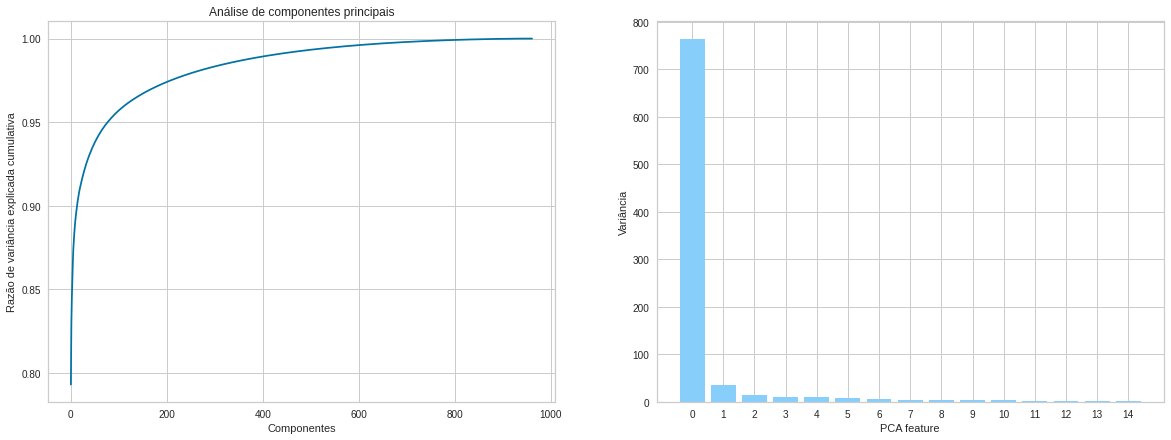

In [40]:
plt.figure(figsize=(20,7))

features = range(pipeline_pca['pca'].n_components_)
print(':', pipeline_pca['pca'].explained_variance_ratio_.cumsum()[:5].round(2))

plt.subplot(1,2,1)
plt.plot(pipeline_pca['pca'].explained_variance_ratio_.cumsum())
plt.title('Análise de componentes principais')
plt.xlabel('Componentes')
plt.ylabel('Razão de variância explicada cumulativa')

plt.subplot(1,2,2)
plt.bar(features[:15], pipeline_pca['pca'].explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variância')
plt.xticks(features[:15]);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que as duas primeira componentes explicam 83% da variância total dos dados, vamos fazer mais alguns gráficos:
    
</div>

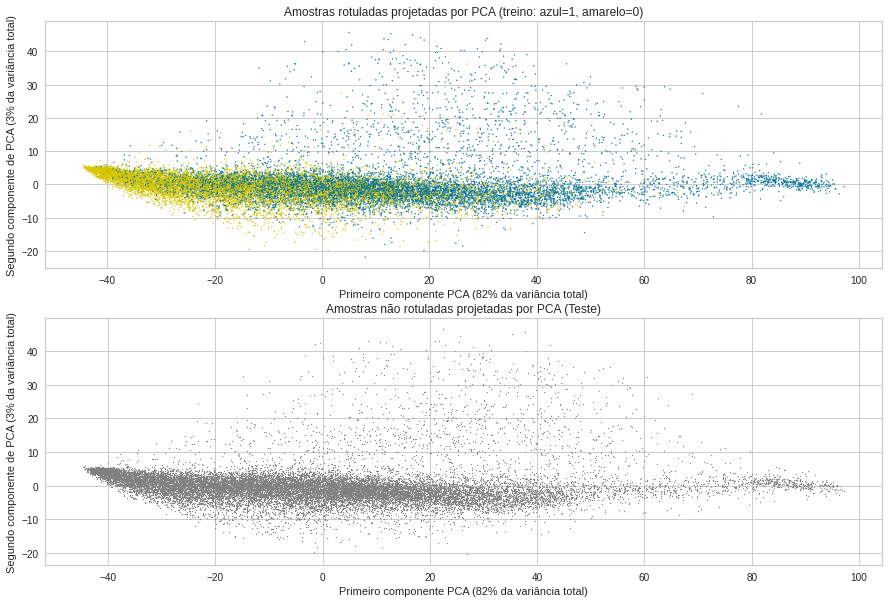

In [41]:
plt.figure(figsize=(15, 10))

plt.subplot(2,1,1)
plt.scatter(Xt[:, 0], Xt[:, 1], s=1, c=y.map({0:'b',1:'y'}))
plt.xlabel('Primeiro componente PCA (82% da variância total)')
plt.ylabel('Segundo componente de PCA (3% da variância total)')
plt.title('Amostras rotuladas projetadas por PCA (treino: azul=1, amarelo=0)')

_ = pipeline_pca.transform(X_test_21)
plt.subplot(2,1,2)
plt.scatter(_[:, 0], _[:, 1], s=1, c='gray')
plt.xlabel('Primeiro componente PCA (82% da variância total)')
plt.ylabel('Segundo componente de PCA (3% da variância total)')
plt.title('Amostras não rotuladas projetadas por PCA (Teste)');
#plt.gca().set_aspect('equal');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

</div>

In [42]:
%%time 

n_components  = 2
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]
pca           = ('pca', PCA(n_components=n_components, random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])

pipeline_pca.fit(X_21)

X_21[pca_feats]      = pipeline_pca.fit_transform(X_21)
X_test_21[pca_feats] = pipeline_pca.fit_transform(X_test_21)

CPU times: user 10.6 s, sys: 763 ms, total: 11.4 s
Wall time: 6.79 s


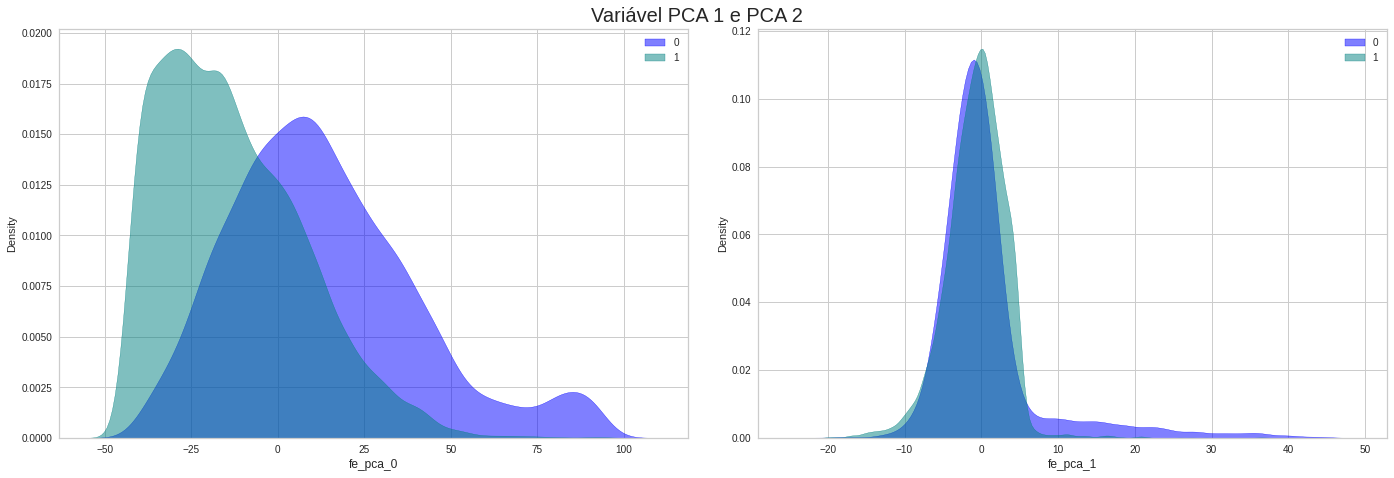

In [43]:
plt.figure(figsize=(20,7))

_ = X_21.copy() 
_[target] = y 

for i,feature in enumerate(pca_feats):
    plt.subplot(1,2,i+1)
    sns.kdeplot(_[_[target]==0][feature],color='blue', alpha=0.5, label='0', shade=True)
    sns.kdeplot(_[_[target]==1][feature],color='teal', alpha=0.5, label='1', shade=True)  
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('Variável PCA 1 e PCA 2', fontsize=20)
plt.tight_layout(pad=3.0);

In [44]:
X_21[pca_feats].describe()

,fe_pca_0,fe_pca_1
count,2.000000e+04,2.000000e+04
mean,-9.094947e-17,-3.979039e-17
std,2.762232e+01,5.916146e+00
min,-4.448542e+01,-2.182006e+01
25%,-2.097714e+01,-2.984480e+00
50%,-3.171765e+00,-6.100147e-01
75%,1.590690e+01,1.699162e+00
max,9.728304e+01,4.566960e+01


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar no primeiro gráfico, áreas que não se sobrepÕe em relação as classes de classificações, quando olhamos para o segundo gráfico tem uma sobreposição das áreas das classes, isso torna a classificação dos modelos difícil, vamos dar uma olha na correlação dessas variáveis. 
    
</div>

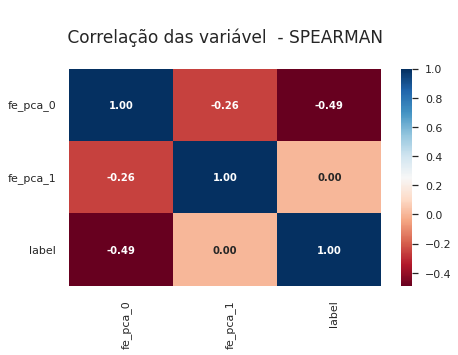

In [45]:
plt.figure(figsize=(7,4))
feature_corr = \
    utility.graf_feature_corr(df_         = _[pca_feats+[target]],                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = False, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

No gráfico de correlação fica claro que a primeira PCA tem o maior porder preditivo, como a segunda PCA tem um valor muito baixo vamos fazer a exclusão.  
    
</div>

In [46]:
feature_drop = ['fe_pca_1']
X_21.drop(feature_drop, axis=1, inplace=True)
X_test_21.drop(feature_drop, axis=1, inplace=True)

In [47]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_02_lgbm_nb_pca')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_21,
                 y_               = y, 
                 X_test_          = X_test_21,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 - 0h 1m 39s / L.Loss: 0.51999 - 0h 2m 29s
# L.Loss: 0.52089 - 0h 1m 36s / L.Loss: 0.52004 - 0h 2m 34s


=> LGBM
Fold 1 => L.Loss: 0.51662 - F1-score: 0.72000 - AUC:0.73050 - 0h 0m 38s
Fold 2 => L.Loss: 0.50115 - F1-score: 0.74376 - AUC:0.74850 - 0h 0m 37s
Fold 3 => L.Loss: 0.52415 - F1-score: 0.71186 - AUC:0.71950 - 0h 0m 41s
Fold 4 => L.Loss: 0.51376 - F1-score: 0.71730 - AUC:0.73200 - 0h 0m 38s
Fold 5 => L.Loss: 0.52621 - F1-score: 0.70710 - AUC:0.71750 - 0h 0m 40s
Fold 6 => L.Loss: 0.52034 - F1-score: 0.70205 - AUC:0.71650 - 0h 0m 37s
Fold 7 => L.Loss: 0.50643 - F1-score: 0.72392 - AUC:0.73800 - 0h 0m 37s
Fold 8 => L.Loss: 0.51707 - F1-score: 0.72055 - AUC:0.73550 - 0h 0m 39s
Fold 9 => L.Loss: 0.53599 - F1-score: 0.69439 - AUC:0.70600 - 0h 0m 41s
Fold 10 => L.Loss: 0.53867 - F1-score: 0.70052 - AUC:0.71100 - 0h 0m 36s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52004 - 0h 6m 29s

CPU times: user 6min 28s, sys: 3.3 s, total: 6min 31s
Wall time: 6min 30s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Não teve melhoria na submissão, mas vou permanecer com a variável.
    
</div>

## 2.2. Clustering

In [48]:
X_22      = X_21.copy()
X_test_22 = X_test_21.copy()

### 2.2.1. Todas as variáveis

In [49]:
feture_pca = X_22.columns.to_list()
feture_pca.remove('fe_pca_0')

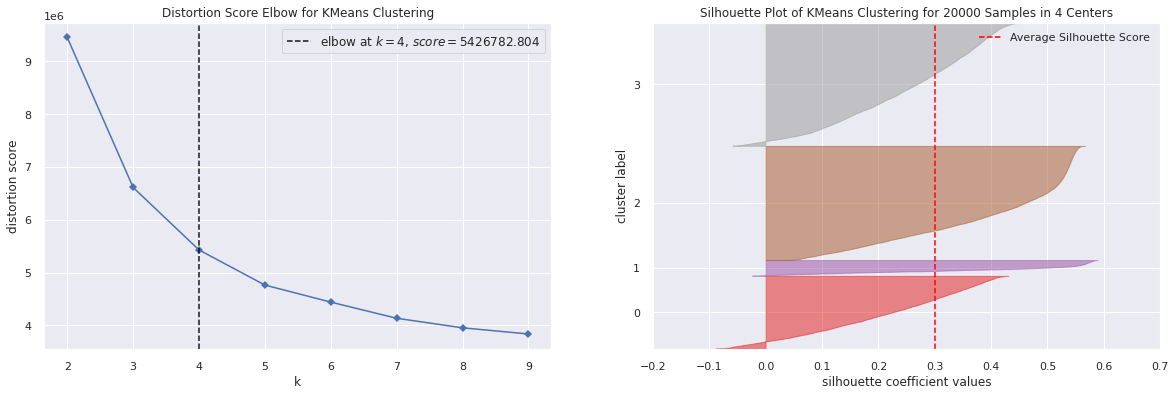

CPU times: user 5min 5s, sys: 16.9 s, total: 5min 22s
Wall time: 4min 9s


In [50]:
%%time 
sc1 = StandardScaler().fit(X_22[feture_pca])

_ = pd.DataFrame(sc1.fit_transform(X_22[feture_pca].copy()), columns=feture_pca)

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_1 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_1, ax=axs1[1])

sv.fit(_)
sv.show();

### 2.2.2. Utilizando PCA

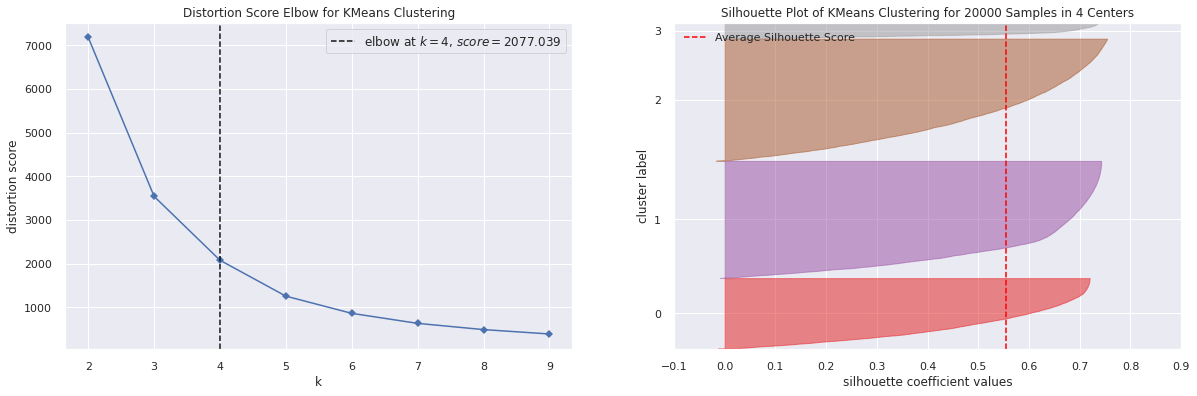

CPU times: user 13.2 s, sys: 423 ms, total: 13.6 s
Wall time: 13.4 s


In [51]:
%%time 

sc2 = StandardScaler() 
_   = pd.DataFrame(sc2.fit_transform(pd.DataFrame(X_21.copy()['fe_pca_0'])), columns=['fe_pca_0'])

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_2 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_2, ax=axs1[1])

sv.fit(_)
sv.show();

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Utilizando PCA temos os clusters com melhor silhjouette e melhor distribuições em relação ao utilizar todas as variáveis para gera os clusters. 
    
Vamos gerar os clusters nos dados de treino e teste.
    
</div>

In [52]:
%%time 

X_22['fe_cluster_kmeans']      = model_2.fit_predict(sc2.fit_transform(X_22))
X_test_22['fe_cluster_kmeans'] = model_2.fit_predict(sc2.fit_transform(X_test_22))

CPU times: user 33.6 s, sys: 2.39 s, total: 36 s
Wall time: 31.2 s


In [53]:
X_22.filter(regex=r'fe').head()

,fe_pca_0,fe_cluster_kmeans
id,,
0,-12.301991,2
1,11.357113,2
2,-14.872122,0
3,-4.639219,2
4,-37.319743,0


In [54]:
%%time 
model_bgmm = BayesianGaussianMixture(n_components    = k, 
                                       covariance_type = 'full', 
                                       n_init          = 3,
                                       init_params     = "kmeans",
                                       random_state    = seed) 

X_22['fe_cluster_bgmm_pca']      = model_bgmm.fit_predict(X_22[['fe_pca_0']])
X_test_22['fe_cluster_bgmm_pca'] = model_bgmm.fit_predict(X_test_22[['fe_pca_0']])

CPU times: user 12.1 s, sys: 9.79 s, total: 21.9 s
Wall time: 11.3 s


### 2.2.3. Gráfico de análise

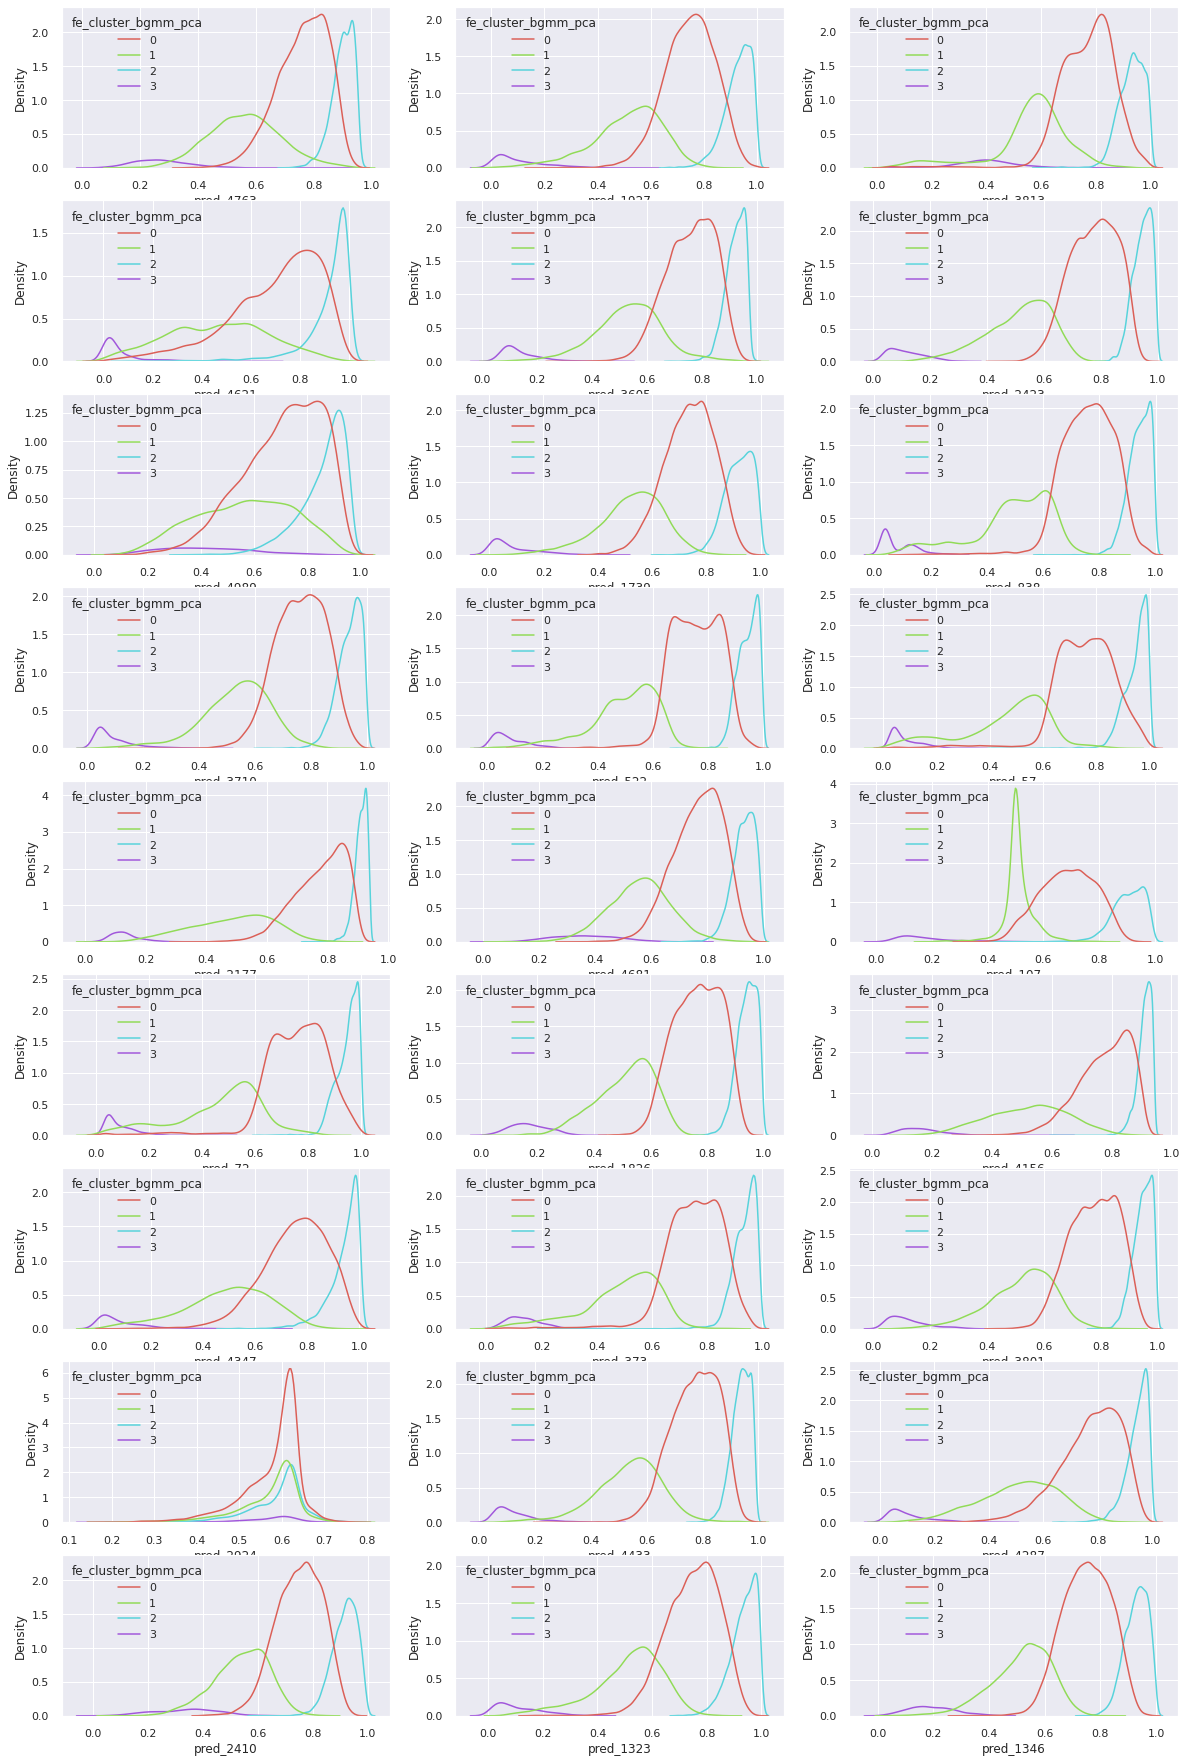

In [55]:
feature_sample = X_22.sample(27, axis='columns').columns.to_list()
row            = int(len(feature_sample)/3) + 1

f,ax = plt.subplots(figsize=(20,35))

for i, feature in enumerate(feature_sample):
    plt.subplot(row, 3 , i+1)
    sns.kdeplot(data=X_22, x=feature, hue="fe_cluster_bgmm_pca", palette=sns.color_palette("hls", k));
    
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que os clusters conseguem fazer a separação dos dados, vamos dar uma olhada na correlação das variáveis criadas. 
    
</div>

In [56]:
feature_corr = ['fe_pca_0','fe_cluster_kmeans', 'fe_cluster_bgmm_pca', target]

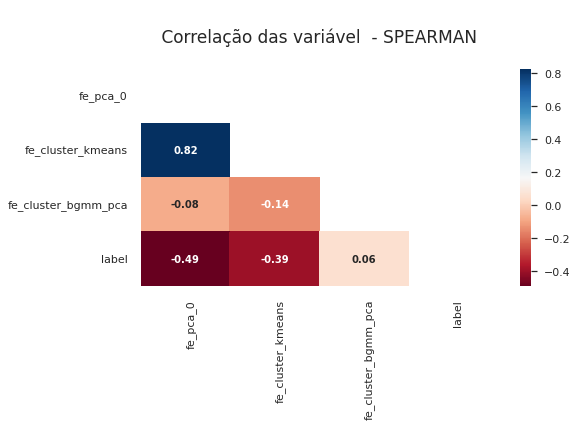

In [57]:
plt.figure(figsize=(8,4))
_ = X_22.copy() 
_[target] = y

feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Temos um ponto interessante nos cluster, a correlção do cluster gerado pelo kmeans é negativa, o que pode puxa o score para baixo.

</div>

### 2.2.4. Criar dammy

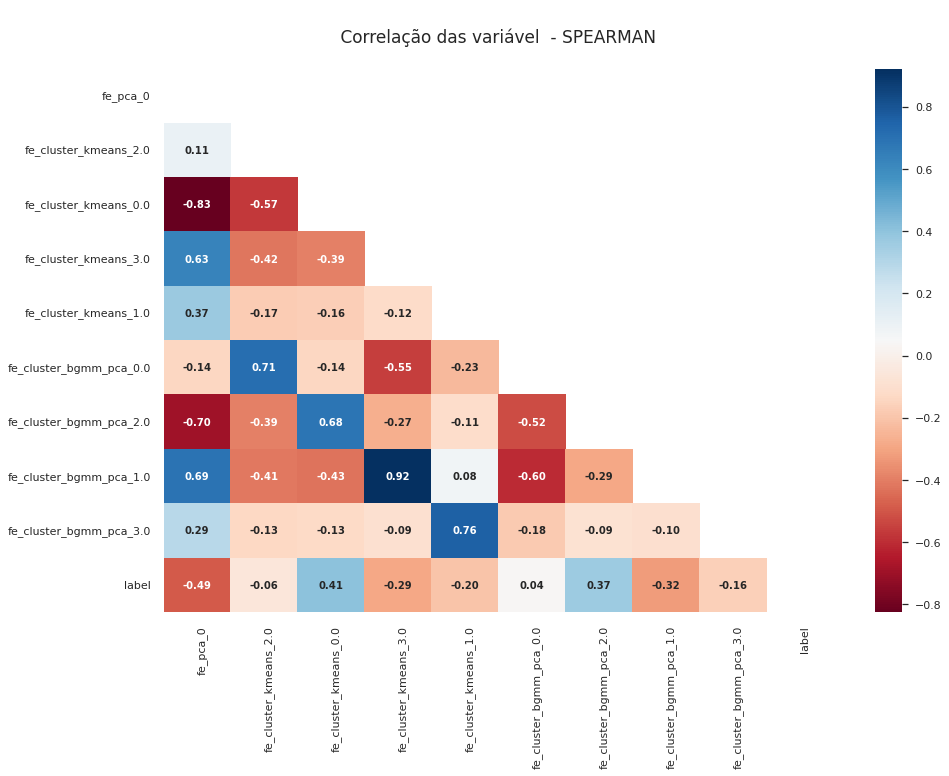

In [58]:
encoder = ce.OneHotEncoder(cols           = ['fe_cluster_bgmm_pca', 'fe_cluster_kmeans'],
                           handle_unknown = 'return_nan',
                           return_df      = True,
                           use_cat_names  = True)

encoder.fit(X_22)

_            = encoder.fit_transform(X_22)
_[target]    = y
feature_corr = _.filter(regex=r'fe_').columns.to_list()

plt.figure(figsize=(15,10))
feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr+ [target]],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Me parece que criar variáveis <b>One Hot Encoding</b> da variável cluster seja  relevante, sendo assim, vamos implentar dentro de um pipeline a criação da variáveis dammies.   
    
</div>

In [59]:
X_22.drop('fe_cluster_kmeans', axis=1, inplace=True)
X_test_22.drop('fe_cluster_kmeans', axis=1, inplace=True)

In [60]:
X_22.filter(regex=r'fe_').head()

,fe_pca_0,fe_cluster_bgmm_pca
id,,
0,-12.301991,0
1,11.357113,0
2,-14.872122,0
3,-4.639219,0
4,-37.319743,2


In [61]:
X_test_22.filter(regex=r'fe_').head()

,fe_pca_0,fe_cluster_bgmm_pca
0,-15.801780,0
1,-12.243219,0
2,20.429383,3
3,6.996434,0
4,13.390765,0


In [62]:
X_22.shape, X_test_22.shape

((20000, 964), (20000, 964))

### 2.2.5. Modelo sem dammy

In [63]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_03_lgbm_nb_02_cluster_sem_dammy')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_22,
                 y_               = y, 
                 X_test_          = X_test_22,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 - 0h 1m 39s / L.Loss: 0.51999 - 0h 2m 29s
# L.Loss: 0.52089 - 0h 1m 36s / L.Loss: 0.52004 - 0h 2m 34s
# L.Loss: 0.52118 - 0h 1m 37s / L.Loss: 0.52020


=> LGBM
Fold 1 => L.Loss: 0.51642 - F1-score: 0.71946 - AUC:0.72900 - 0h 0m 36s
Fold 2 => L.Loss: 0.50230 - F1-score: 0.73765 - AUC:0.74250 - 0h 0m 44s
Fold 3 => L.Loss: 0.52320 - F1-score: 0.71443 - AUC:0.72300 - 0h 0m 46s
Fold 4 => L.Loss: 0.51479 - F1-score: 0.72251 - AUC:0.73500 - 0h 0m 37s
Fold 5 => L.Loss: 0.52617 - F1-score: 0.71207 - AUC:0.72100 - 0h 0m 37s
Fold 6 => L.Loss: 0.52042 - F1-score: 0.69556 - AUC:0.71200 - 0h 0m 38s
Fold 7 => L.Loss: 0.50690 - F1-score: 0.72296 - AUC:0.73750 - 0h 0m 40s
Fold 8 => L.Loss: 0.51777 - F1-score: 0.71716 - AUC:0.73300 - 0h 0m 38s
Fold 9 => L.Loss: 0.53648 - F1-score: 0.68842 - AUC:0.70400 - 0h 0m 39s
Fold 10 => L.Loss: 0.53921 - F1-score: 0.69933 - AUC:0.70850 - 0h 0m 38s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52037 - 0h 6m 38s

CPU times: user 6min 30s, sys: 4.01 s, total: 6min 34s
Wall time: 6min 40s


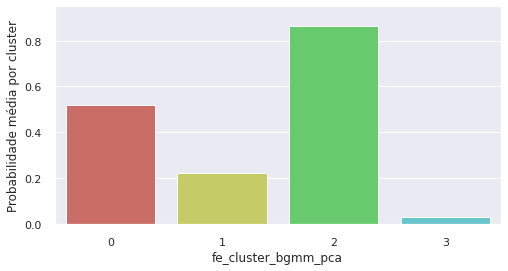

In [64]:
_ =  X_22.copy()
_['pred_proba'] =  y
_ = _.groupby('fe_cluster_bgmm_pca')['pred_proba'].mean()
f,ax = plt.subplots(figsize=(8,4))
sns.barplot(x=_.index, y=_.values, palette=sns.color_palette("hls", 6) );
ax.set_ylabel("Probabilidade média por cluster");
ax.set_ylim([0.,0.95]);

### 2.2.6. Modelo com dammy 

In [65]:
jb.dump(X_22, path+path_data+'pkl/X_train_feature_eng_nb_02_n2_03.pkl.z')
jb.dump(X_test_22, path+path_data+'pkl/X_test_feature_eng_nb_02_n2_03.pkl.z')

['/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/Data/pkl/X_test_feature_eng_nb_02_n2_03.pkl.z']

# 3. Modelagem

## 3.2. Classificadores e pipeline

In [66]:
# Paremetros 

params_xgb  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'max_depth'        : 7,  
    'colsample_bytree' : 0.8, 
    'max_leaves'       : 10,    # 0.52463    
    'subsample'        : 0.95,  # 0.52460      
    
    #'lambda'           : 1.2,
    #'alpha'            : 0.9,   # 
    #'min_child_weight' : 1e-3,
    #'colsample_bylevel': 0.95,    
    # 'learning_rate'    : 1e-1,
     #'sampling_method'  : 'uniform',  # 0.52460   
    'n_jobs'           : -1,
    'seed'             : seed}

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 100,
    'max_depth'         : 7,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

param_ext   = {
    'n_estimators'     : 500,
    'max_depth'        : 7, 
    'min_samples_leaf' : 12,         
    'n_jobs'           : -1,
    'random_state'     : seed}

param_lr    = {
    'max_iter'      : 1000, 
    'C'             : 0.0001, 
    'penalty'       : 'l2', 
    'fit_intercept' : True,
    'solver'        : 'newton-cg'}

param_mlp   = {
    'learning_rate' : 'adaptive',
    'alpha'         : 0.5,
    'random_state'  : seed}

param_hbc   = {
    'max_iter'            : 100,
    'validation_fraction' : 0.1,
    'random_state'        : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_lr   = LogisticRegression(**param_lr)
model_knn  = KNeighborsClassifier(n_neighbors=225)
model_mlp  = MLPClassifier(**param_mlp) 
model_xgb  = xgb.XGBClassifier(**params_xgb) 
model_ext  = ExtraTreesClassifier(**param_ext)
model_lgbm = lgb.LGBMClassifier(**param_lgbm)
model_rf   = RandomForestClassifier(**param_rf)
model_hbc  = HistGradientBoostingClassifier(**param_hbc)

pca    = ('pca', PCA(n_components=80, random_state=seed))
scaler = StandardScaler() 

feature_encoder_bin = X_22.filter(regex='fe_c').columns.to_list()


# Processamento
encoder_bin       = ('encoder_binary', ce.BinaryEncoder(cols=feature_encoder_bin, return_df=True))
processar         = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Pipelne 
pipeline_lr   = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_lr)])
pipeline_knn  = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_knn)])
pipeline_mlp  = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_mlp)])
pipeline_xgb  = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_xgb)])
pipeline_ext  = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_ext)])
pipeline_lgbm = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_lgbm)])
pipeline_rf   = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_rf)])
pipeline_hbc  = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, ('model', model_hbc)])

## 3.3. Funções da modelagem

## 3.4. Treino

In [67]:
%%time

models = [ 
    ('LR', pipeline_lr, 1, 'nb_02_n2_05_lr_nb_01'), 
    ('KNN', pipeline_knn, 1, 'nb_02_n2_06_knn_nb_01'),     
    ('MLP', pipeline_mlp, 1, 'nb_02_n2_07_mlp_nb_01' ),
    ('XGB', pipeline_xgb, 1, 'nb_02_n2_08_xgb_nb_01'),    
    ('ExTrees', pipeline_ext, 1, 'nb_02_n2_09_extrees_nb_01'),    
    ('LGBM', pipeline_lgbm, 1, 'nb_02_n2_10_lgbm_nb_01'), 
    ('RForest', pipeline_rf, 1, 'nb_02_n2_11_rforest_nb_01'),
    ('HBoosting', pipeline_hbc, 1,'nb_02_n2_12_hboosting_nb_01')
    ]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_       = models, 
                 X_            = X_22.copy(),
                 y_            = y, 
                 X_test_       = X_test_22.copy(),                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True, 
                 save_ensamble_= True,
                 level_        = '2'
                )


# L.Loss: 0.52108 - 0h 1m 39s / L.Loss: 0.51999 - 0h 2m 29s
# L.Loss: 0.52089 - 0h 1m 36s / L.Loss: 0.52004 - 0h 2m 34s
# L.Loss: 0.52118 - 0h 1m 37s / L.Loss: 0.52020


=> LR
Fold 1 => L.Loss: 0.52747 - F1-score: 0.71739 - AUC:0.72700 - 0h 0m 10s
Fold 2 => L.Loss: 0.51129 - F1-score: 0.73330 - AUC:0.73850 - 0h 0m 9s
Fold 3 => L.Loss: 0.53519 - F1-score: 0.70281 - AUC:0.70950 - 0h 0m 9s
Fold 4 => L.Loss: 0.52332 - F1-score: 0.72435 - AUC:0.73400 - 0h 0m 10s
Fold 5 => L.Loss: 0.53310 - F1-score: 0.70279 - AUC:0.71200 - 0h 0m 10s
Fold 6 => L.Loss: 0.52774 - F1-score: 0.70417 - AUC:0.71600 - 0h 0m 9s
Fold 7 => L.Loss: 0.51777 - F1-score: 0.70755 - AUC:0.72100 - 0h 0m 10s
Fold 8 => L.Loss: 0.52508 - F1-score: 0.72432 - AUC:0.73700 - 0h 0m 10s
Fold 9 => L.Loss: 0.54122 - F1-score: 0.69403 - AUC:0.70550 - 0h 0m 9s
Fold 10 => L.Loss: 0.54982 - F1-score: 0.69753 - AUC:0.70600 - 0h 0m 10s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52920 - 0h 1m 40s

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10000
           1       0.74      0.69      0.71     1000

,score
LGBM,0.52018
HBoosting,0.52366
RForest,0.52433
ExTrees,0.52858
XGB,0.52866
LR,0.52920
KNN,0.54078
MLP,0.58501



CPU times: user 1h 56min 56s, sys: 27min 12s, total: 2h 24min 9s
Wall time: 1h 43min 40s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões todos os modelos tiveram score melhor que no treinamento na LB pública, o melhor modelo foi <b>LGBM</b>, abaixo as submissÕes:

- <b>0.51562 -> LGBMClassifier</b>;
- -> HistGradientBoostingClassifier. 
- -> XGBClassifier; 
- -> RandomForestClassifier;
- -> LogisticRegression;
- -> ExtraTreesClassifier; 
- -> KNeighborsClassifier; 
- -> MLPClassifier; 

</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. ANÁLISE DAS PREVISÕES </h1>    
</div>

## 4.1. Distribuição e calibração

In [68]:
#df_pred_tr = jb.load(path+path_data +'pkl/df_pred_tr.pkl.z' )
#df_pred_ts = jb.load(path+path_data +'pkl/df_pred_ts.pkl.z' )

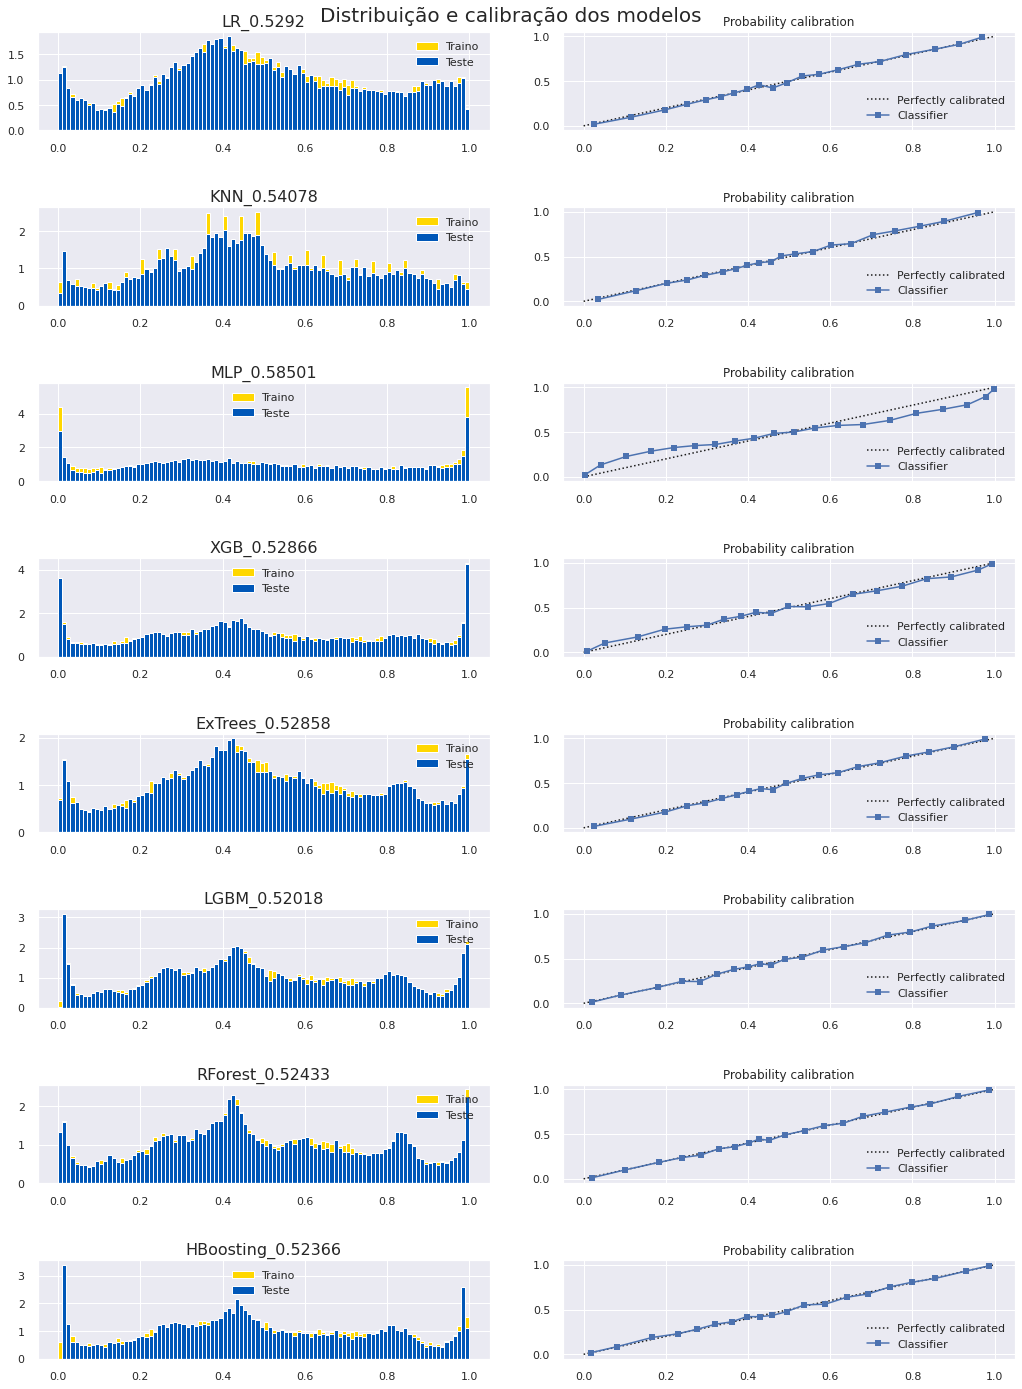

In [75]:
cols = df_pred_tr.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 20)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A maioria dos modelos tem um boa calibração, exceto a MLP, em relação a distribuição das previsões em ambos os datasets apresentam a mesma distribuição. Alguns modelo pondem ser melhorados com ajuste de parametros. 
    
    
</didv>

## 4.2. Correlação

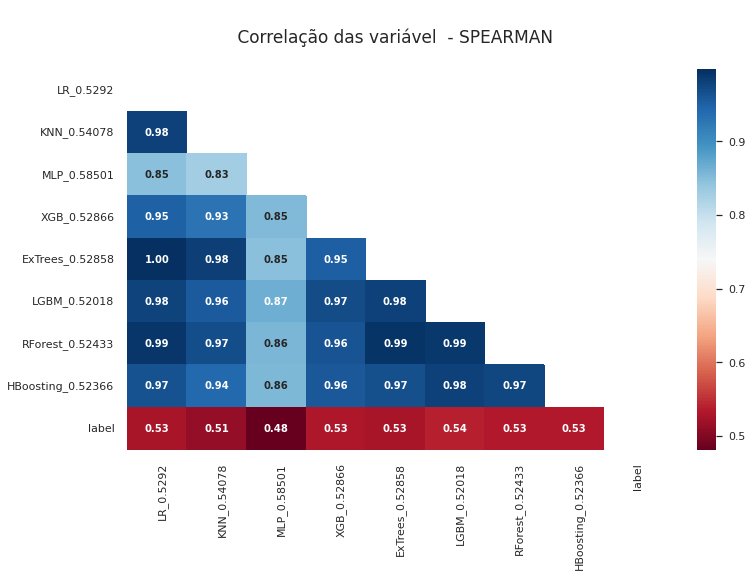

In [76]:
plt.figure(figsize=(12,7))
_ = df_pred_tr.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman'
                              );
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Todos os modelos tem uma baixa correlação com a variável alvo, porem entre as previsões temos uma autocorreção, não vou me preocupar neste momento com essa auto correlação, pois mais tarde vamos fazer uma seleção da melhores variáveis para o próximo nível.     
    
</div>

## 4.3. Média ponderada

Vamos fazer dos modelos. 

In [77]:
def get_oof_roc_score(df_, y_, weight_, pred_model1_, pred_model2_):
    blend_pred = (df_[pred_model1_]*weight_)+(df_[pred_model2_]*(1 - weight_))
    score      = log_loss(y_, blend_pred)
    return score

In [78]:
%%time 

feature_mdl      = df_pred_tr.columns.to_list()
myscores_mdl     = []
best_mdl_score_1 = []

for mdl_1 in feature_mdl:     
    f = feature_mdl.copy() 
    f.remove(mdl_1)   
    for mdl_2 in f: 
        myscores    = {}
        best        = 1.
        best_weight = 0.

        for weight in range(100):            
            weight /= 100.
            score = get_oof_roc_score(df_          = df_pred_tr, 
                                      y_           = y,
                                      weight_      = weight, 
                                      pred_model1_ = mdl_1,  
                                      pred_model2_ = mdl_2)

            if score < best:
                best        = score
                best_weight = weight                

            myscores[weight] = score

    best_mdl_score_1.append({'model_1' : mdl_1, 
                             'model_2' : mdl_2, 
                             'score'   : round(best, 5), 
                             'weight'  : best_weight})

    msg = 'Best Weight: {:2.5f} - Score: {:2.5f} => {} - {}'
    print(msg.format(best_weight, best, mdl_1, mdl_2))  
    
_ = pd.DataFrame(best_mdl_score_1).sort_values('score')

print()
display(_)

print()

Best Weight: 0.25000 - Score: 0.52284 => LR_0.5292 - HBoosting_0.52366
Best Weight: 0.08000 - Score: 0.52351 => KNN_0.54078 - HBoosting_0.52366
Best Weight: 0.13000 - Score: 0.52251 => MLP_0.58501 - HBoosting_0.52366
Best Weight: 0.37000 - Score: 0.52150 => XGB_0.52866 - HBoosting_0.52366
Best Weight: 0.26000 - Score: 0.52281 => ExTrees_0.52858 - HBoosting_0.52366
Best Weight: 0.78000 - Score: 0.51989 => LGBM_0.52018 - HBoosting_0.52366
Best Weight: 0.46000 - Score: 0.52188 => RForest_0.52433 - HBoosting_0.52366
Best Weight: 0.54000 - Score: 0.52188 => HBoosting_0.52366 - RForest_0.52433



,model_1,model_2,score,weight
5,LGBM_0.52018,HBoosting_0.52366,0.51989,0.78
3,XGB_0.52866,HBoosting_0.52366,0.52150,0.37
6,RForest_0.52433,HBoosting_0.52366,0.52188,0.46
7,HBoosting_0.52366,RForest_0.52433,0.52188,0.54
2,MLP_0.58501,HBoosting_0.52366,0.52251,0.13
4,ExTrees_0.52858,HBoosting_0.52366,0.52281,0.26
0,LR_0.5292,HBoosting_0.52366,0.52284,0.25
1,KNN_0.54078,HBoosting_0.52366,0.52351,0.08



CPU times: user 48 s, sys: 503 ms, total: 48.5 s
Wall time: 50.9 s


In [79]:
mdl_1 = str(_[:1].values[:,:1]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
mdl_2 = str(_[:1].values[:,1:2]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
weight = np.float64(str(_[:1].values[:,3:4]).replace("[", '').replace("'",'').replace("]", '').replace("'",''))

name = 'nb_02_n2_13_emsable_average_{}_{}.csv'.format(mdl_1, mdl_2)
df_submission['pred'] = df_pred_ts[mdl_1]*weight + df_pred_ts[mdl_2]*(1-weight)
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51598 - n2_01_emsable_average_LGBM_0.52022_HBoosting_0.52385.csv

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Na submissão da media ponderada do HBoosting e RForest se mostrou promissor com score de 0.51669, passando a ser melhor que a maior dos modelos. 
 
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

# 5. Terceiro Nível
Nesta parte do processo vamos pegar as previsões que foram geradas no segundo nível e fazer novas previsões com os modelos que foram utilizados, ao fazer as previsões vamos remover o modelo que faz a previsão do dataset.  

In [80]:
df_pred_tr.columns

Index(['LR_0.5292', 'KNN_0.54078', 'MLP_0.58501', 'XGB_0.52866',
       'ExTrees_0.52858', 'LGBM_0.52018', 'RForest_0.52433',
       'HBoosting_0.52366'],
      dtype='object')

- Primeiro renomeamos as colunas dos datasets, com a renomeação temos facilidade para remover o modelo do dataset. 

In [81]:
df_tr = df_pred_tr.copy()
df_ts = df_pred_ts.copy()

cols_new = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 
            'LGBM', 'RForest','HBoosting']

df_tr.columns= cols_new
df_ts.columns= cols_new

df_tr.head()

,LR,KNN,MLP,XGB,ExTrees,LGBM,RForest,HBoosting
0,0.754325,0.671111,0.571037,0.538874,0.760055,0.694034,0.785825,0.724506
1,0.351020,0.333333,0.299713,0.267511,0.368499,0.307193,0.365588,0.327697
2,0.570888,0.586667,0.659458,0.656776,0.583929,0.578687,0.587535,0.594364
3,0.558906,0.555556,0.579910,0.603624,0.553649,0.575460,0.606958,0.591635
4,0.869053,0.853333,0.926261,0.947835,0.843832,0.799431,0.836177,0.861272


- Nos passos abaixo temos a seguinte sequência: 

In [82]:
%%time 

# Lista com os modelos para gerar as previsões 
models_n3 = [
    ('RForest', model_rf, 1, 'nb_02_n3_14_rf'), 
    ('XGB', model_xgb, 1, 'nb_02_n3_15_xgb'), 
    ('LGBM', model_lgbm, 1, 'nb_02_n3_16_lgbm'), 
    ('HBoosting', model_hbc, 1, 'nb_02_n3_17_hbc'), 
    ('LR', model_lr, 1, 'nb_02_n3_18_lr')
]
      
# Dataset para armazenar as previsões
df_pred_tr_n3   = pd.DataFrame() 
df_pred_ts_n3   = pd.DataFrame()
df_score_mdl_n3 = pd.DataFrame()

# Loop para treina cada modelo 
for mdl in models_n3: 
    
    # Lista com o nome de cada modelo
    cols = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 'LGBM', 'HBoosting', 'RForest']
    
    # remoção da colona, previsões do modelo, do treinamento. 
    cols.remove(mdl[0])
    
    # Chama uma função para treinar o modelo e retorna as previsões
    _tr_n3, _ts_n3, _score_mdl_n3 = \
        model_cv_fit(models_          = [mdl], 
                     X_               = df_tr[cols],
                     y_               = y, 
                     X_test_          = df_ts[cols],                  
                     path_            = path, 
                     seed_            = seed,
                     target_          = 'pred',
                     create_sub_      = True, 
                     n_splits_        = 10,
                     print_report_    = False, 
                     print_score_mdl_ = False, 
                     save_ensamble_   = True,
                     level_           = '3'
                    ) 
    
    # Armazeno as previsões para o próximo nível 
    df_pred_tr_n3   = pd.concat([df_pred_tr_n3, _tr_n3], axis=1)
    df_pred_ts_n3   = pd.concat([df_pred_ts_n3, _ts_n3], axis=1)
    df_score_mdl_n3 = pd.concat([df_score_mdl_n3, _score_mdl_n3]) 
    
del _tr_n3, _ts_n3, _score_mdl_n3 

df_score_mdl_n3.sort_values(by='score',ascending=True)  

# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv


=> RForest
Fold 1 => L.Loss: 0.51596 - F1-score: 0.72398 - AUC:0.73350 - 0h 0m 2s
Fold 2 => L.Loss: 0.50298 - F1-score: 0.74044 - AUC:0.74550 - 0h 0m 2s
Fold 3 => L.Loss: 0.52377 - F1-score: 0.71229 - AUC:0.72250 - 0h 0m 2s
Fold 4 => L.Loss: 0.51540 - F1-score: 0.71252 - AUC:0.73250 - 0h 0m 2s
Fold 5 => L.Loss: 0.52448 - F1-score: 0.70961 - AUC:0.72050 - 0h 0m 2s
Fold 6 => L.Loss: 0.52320 - F1-score: 0.70464 - AUC:0.72000 - 0h 0m 2s
Fold 7 => L.Loss: 0.50902 - F1-score: 0.71835 - AUC:0.73300 - 0h 0m 2s
Fold 8 => L.Loss: 0.51750 - F1-score: 0.70820 - AUC:0.72600 - 0h 0m 2s
Fold 9 => L.Loss: 0.53362 - F1-score: 0.69097 - AUC:0.70750 - 0h 0m 2s
Fold 10 => L.Loss: 0.53818 - F1-score: 0.70115 - AUC:0.71400 - 0h 0m 2s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52041 - 0h 0m 27s


=> XGB
Fold 1 => L.Loss: 0.52437 - F1-score: 0.71480 - AUC:0.72150 - 0h 0m 2s
Fold 2 => L.Loss: 0.51043 - F1-score: 0.73915 - AUC:0.74450 - 0h 0m 2s
Fold 3 => L.

,score
RForest,0.52041
LGBM,0.52310
HBoosting,0.52379
XGB,0.52610
LR,0.52813


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

O melhor modelo foi <b>R. Forest</b> tando no treinamento e na LB, batendo o score anterior. Vamos fazer algumas análise e gerar uma média ponderada.     
    
</div>

In [ ]:
# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv 


# 0.51439 - model_rf_n3_0.52179_folds_10_oof.csv.csv     
# 0.51476 - model_xgb_n3_0.52171_folds_10_oof.csv.csv
# 0.51454 - model_lgbm_n3_0.52242_folds_10_oof.csv.csv
# 0.51527 - model_hbc_n3_0.52537_folds_10_oof.csv.csv

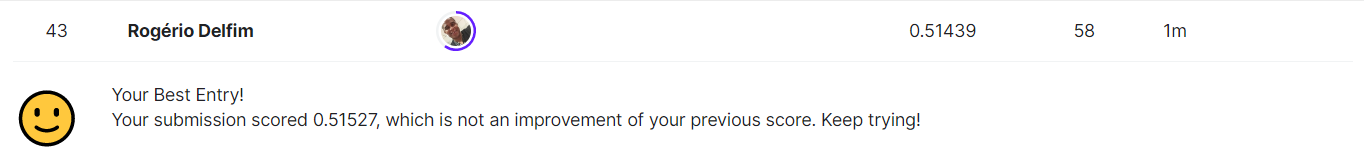

## 5.1. Distribuição e calibração

In [78]:
cols = df_pred_tr_n3.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 15)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr_n3[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts_n3[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr_n3[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<Figure size 1080x1080 with 0 Axes>

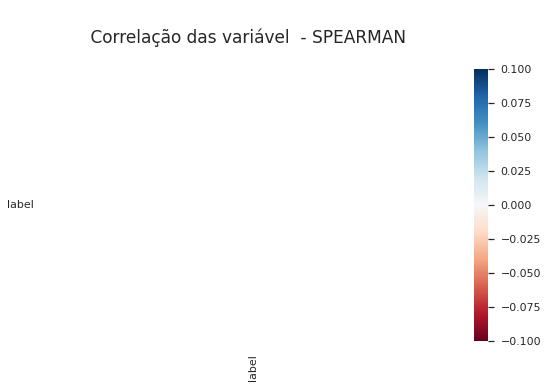

In [79]:
plt.figure(figsize=(9,5))
_ = df_pred_tr_n3.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman'
                              )

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Observamos que a distribuição dos datasets(treino/teste) seguem a mesma distribuição, porém com a maioria das probabilidade entre 0.2 e 0.8, ainda temos um espaço para melhoria. Em relação a calibração a maioria dos modelos tem uma boa calibragem, exceto LR e XGB. <p>


</div> 

In [1]:
cols_n3 = ['RForest', 'XGB', 'LGBM', 'HBoosting', 'LR' ] 
df_pred_ts_n3.columns= cols_n3
df_pred_ts_n3.head()

NameError: ignored

In [ ]:
w1 = .9
w2 = .1
name = 'nb_02_n4_19_emsable_average_RForest_LGBM_w1_{}_w2_{}.csv'.format(w1, w2)
df_submission['pred'] = df_pred_ts_n3['RForest']*w1 + df_pred_ts_n3['XGB'] * w2
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51508 sub_emsable_RForest_LGBM_n3.csv

![image.png](attachment:image.png)

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. CONCLUSÃO </h1>    
</div>

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    

<p><br>
    
     
<b>PRÓXIMOS PASSOS:</b> <br>   
 
    
    
</div>